# Анализ предсказаний курсов валют с помощью LSTM модели в зависимости от ключевых индикаторов на фондовом рынке

## Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import joblib
import warnings
from pathlib import Path
import os

warnings.filterwarnings('ignore')

## Загружаем данные

Описание данных:

- Файлы находящиеся в директории описанной константой `PATH_DATASET` и имеющие расширение `xlsx` будут загружены. Если число строк больше или равно значению переменной `MIN_ROW`, то данные будут соединены в один дата фрейм по столбцу `Дата`.

- В директории располагаются данные о ключевых индикаторах фондового рынка и курсах валют. Если в названии файла есть знак `_`, то он определяется как курс валюты и будет считаться таргетом , если нет, то будет определятся как ключевой индикатор фондового рынка и будет считаться признаком.

В дата фрейме название столбца будет соответствовать названию файла

- Данные загружаются с различных фалов Excel и соединяются между собой по столбцу `Дата`. О ходе процесса выводиться информация на консоль.

Файлы могут содержать любую информацию о ключевых показателях фондового рынка и курсах любых валют.

In [2]:
# Расположение данных
PATH_DATASET = './data'
# Минимальное разрешённое количество строк для загрузки
MIN_ROW = 5000

# Хранилище для всех временных таблиц
data_frames = []

# Читаем файлы
p = Path(PATH_DATASET)

for obj in p.iterdir():
    if obj.is_file() and obj.suffix == '.xlsx':
        name_file_all = obj.name
        name_file = obj.stem

        try:
            df_temp = pd.read_excel(obj, engine='openpyxl')

            # Проверим наличие нужных колонок
            if 'Дата' not in df_temp.columns or 'Значение' not in df_temp.columns:
                print(f"❌ Пропущен файл (нет нужных колонок): {name_file_all}")
                continue

            # Обработка
            df_temp['Дата'] = pd.to_datetime(df_temp['Дата'], errors='coerce').dt.normalize()
            df_temp = df_temp.dropna(subset=['Дата'])         # удалим пустые даты
            df_temp = df_temp.drop_duplicates(subset='Дата')  # и дубликаты

            df_temp.rename(columns={'Значение': name_file}, inplace=True)
            df_temp = df_temp[['Дата', name_file]]

            if df_temp.shape[0] < MIN_ROW:
                print(f"⚠️  Файл загружен, но < MIN_ROW: {name_file_all} ({df_temp.shape[0]} строк)")
            else:
                print(f"✅ Файл загружен: {name_file_all} ({df_temp.shape})")

            data_frames.append(df_temp)

        except Exception as e:
            print(f"Ошибка файла {name_file_all}: {e}")

✅ Файл загружен: индекс-мосбиржи.xlsx ((6388, 2))
✅ Файл загружен: s-p-500.xlsx ((6484, 2))
✅ Файл загружен: золото.xlsx ((7278, 2))
✅ Файл загружен: нефть-brent.xlsx ((6777, 2))
✅ Файл загружен: usd_rub.xlsx ((7673, 2))
✅ Файл загружен: серебро.xlsx ((7278, 2))
✅ Файл загружен: cny_rub.xlsx ((5789, 2))


In [3]:
# Объединяем всё по outer join
from functools import reduce

if data_frames:
    data_merged = reduce(lambda left, right: pd.merge(left, right, on='Дата', how='outer'), data_frames)
    data_merged = data_merged.sort_values(by='Дата')  # по порядку

    print(f"Финальный датафрейм: {data_merged.shape}\n")
    print(data_merged.head())

else:
    print("Ни один файл не был загружен.")

Финальный датафрейм: (8186, 8)

        Дата  индекс-мосбиржи  s-p-500  золото  нефть-brent  usd_rub  серебро  \
0 2000-01-01              NaN      NaN     NaN          NaN     27.0      NaN   
1 2000-01-03              NaN  1455.22     NaN        25.73     27.0      NaN   
2 2000-01-04              NaN  1399.42     NaN        24.39      NaN      NaN   
3 2000-01-05           173.00  1402.11     NaN        23.73      NaN      NaN   
4 2000-01-06           186.26  1403.45  246.67        23.62     26.9     4.65   

   cny_rub  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  


In [4]:
# размерность
data_merged.shape

(8186, 8)

## Предобработка данных

In [5]:
# Определяем валюты и индикаторы
currencies = [col for col in data_merged.columns if '_' in col and col != 'Дата']
indicators = [col for col in data_merged.columns if '_' not in col and col != 'Дата']

print(f"💱 Валюты ({len(currencies)}): {currencies}")
print(f"📈 Индикаторы рынка ({len(indicators)}): {indicators}")

# Проверяем пропущенные значения
missing = data_merged.isnull().sum()
print(f"\n⚠️ Пропущенные значения:")
for col, count in missing.items():
    if count > 0:
        print(f"   {col}: {count} ({count/len(data_merged)*100:.1f}%)")

💱 Валюты (2): ['usd_rub', 'cny_rub']
📈 Индикаторы рынка (5): ['индекс-мосбиржи', 's-p-500', 'золото', 'нефть-brent', 'серебро']

⚠️ Пропущенные значения:
   индекс-мосбиржи: 1798 (22.0%)
   s-p-500: 1702 (20.8%)
   золото: 908 (11.1%)
   нефть-brent: 1409 (17.2%)
   usd_rub: 513 (6.3%)
   серебро: 908 (11.1%)
   cny_rub: 2397 (29.3%)


In [6]:
# Заполняем пропущенные значения
data_clean = data_merged.copy()
numeric_columns = data_clean.select_dtypes(include=[np.number]).columns
data_clean[numeric_columns] = data_clean[numeric_columns].fillna(method='ffill').fillna(method='bfill')


print(f"Пропущенных значений после обработки: {data_clean.isnull().sum().sum()}")

Пропущенных значений после обработки: 0


## Анализ кореляций

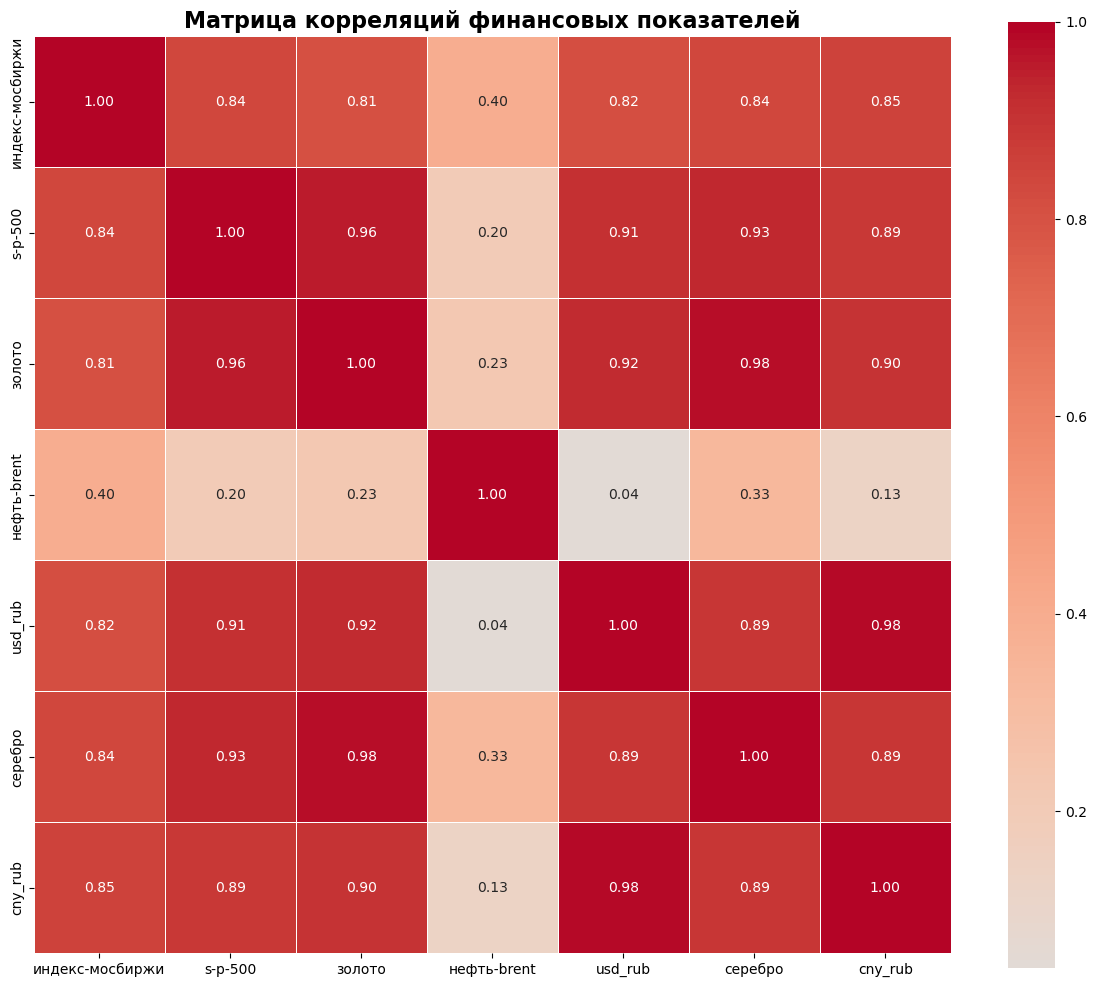

Корреляция с usd_rub:
usd_rub            1.000000
cny_rub            0.984832
золото             0.923278
s-p-500            0.912019
серебро            0.893831
индекс-мосбиржи    0.815913
нефть-brent        0.041246
Name: usd_rub, dtype: float64
Выбрана целевая переменная для прогнозирования: usd_rub


In [25]:
plt.figure(figsize=(12, 10))

# Матрица корреляций только для числовых данных
numeric_data = data_clean.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Построение heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
           square=True, linewidths=0.5, fmt='.2f')
plt.title('Матрица корреляций финансовых показателей', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Корреляция с целевой переменной (если есть валюты)
if currencies:
    target_column = currencies[0]  # Берем первую валюту
    print(f"Корреляция с {target_column}:")
    target_corr = correlation_matrix[target_column].sort_values(ascending=False)
    print(target_corr)
else:
    target_column = numeric_data.columns[0]
    print(f"Целевая переменная: {target_column}")

print(f"Выбрана целевая переменная для прогнозирования: {target_column}")

## Подготовка данных для LSTM

In [8]:
# Настройки модели
SEQUENCE_LENGTH = 90  # Длина временной последовательности
TEST_SIZE = 0.2       # Доля тестовых данных
VAL_SIZE = 0.1        # Доля валидационных данных

print(f"🎯 Целевая переменная: {target_column}")
print(f"📏 Длина последовательности: {SEQUENCE_LENGTH}")

# Подготовка данных
df_model = data_clean.copy()
df_model = df_model.set_index('Дата').sort_index()

# Выбираем признаки
if '_' in target_column:
    # Если целевая переменная - валюта, используем индикаторы как признаки + саму валюту
    features = indicators + [target_column]
else:
    # Иначе используем все числовые колонки
    features = df_model.select_dtypes(include=[np.number]).columns.tolist()

print(f"📊 Используемые признаки ({len(features)}): {features}")

🎯 Целевая переменная: usd_rub
📏 Длина последовательности: 90
📊 Используемые признаки (6): ['индекс-мосбиржи', 's-p-500', 'золото', 'нефть-brent', 'серебро', 'usd_rub']


In [9]:
# Извлекаем данные
data_values = df_model[features].values
print(f"Исходные данные: {data_values.shape}")

Исходные данные: (8186, 6)


In [10]:
# Масштабирование данных
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_values)
print(f"Данные масштабированы: min={scaled_data.min():.3f}, max={scaled_data.max():.3f}")

Данные масштабированы: min=0.000, max=1.000


In [11]:
# Функция создания последовательностей
def create_sequences(data, target_idx, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, target_idx])
    return np.array(X), np.array(y)

In [12]:
# Находим индекс целевой колонки
target_idx = features.index(target_column)
print(f"Индекс целевой колонки: {target_idx}")

Индекс целевой колонки: 5


In [13]:
# Создаем последовательности
X, y = create_sequences(scaled_data, target_idx, SEQUENCE_LENGTH)
print(f"Создано последовательностей: {X.shape[0]}")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")

Создано последовательностей: 8096
   X shape: (8096, 90, 6)
   y shape: (8096,)


In [14]:
# Разделение на train/val/test
train_size = int(len(X) * (1 - TEST_SIZE - VAL_SIZE))
val_size = int(len(X) * VAL_SIZE)

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]
X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"Размеры выборок:")
print(f"   Обучающая: {X_train.shape[0]} образцов")
print(f"   Валидационная: {X_val.shape[0]} образцов")
print(f"   Тестовая: {X_test.shape[0]} образцов")

Размеры выборок:
   Обучающая: 5667 образцов
   Валидационная: 809 образцов
   Тестовая: 1620 образцов


## Создание LSTM модели

In [15]:
# Создание модели
model = Sequential([
    # Первый LSTM слой
    LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    # Второй LSTM слой
    LSTM(units=100, return_sequences=True),
    Dropout(0.2),

    # Третий LSTM слой
    LSTM(units=100, return_sequences=True),
    Dropout(0.2),

    # Четвертый LSTM слой
    LSTM(units=100, return_sequences=False),
    Dropout(0.2),

    # Полносвязный слой
    Dense(units=50, activation='relu'),
    Dropout(0.2),

    # Выходной слой
    Dense(units=1)
])



In [16]:
# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mean_squared_error',
    metrics=['mae']
)


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 90, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 90, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,101 (1.10 MB)

 Trainable params: 289,101 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

## Обучение модели

In [17]:
# Настройки обучения
EPOCHS = 50       # Количество эпох (можно увеличить для лучшего качества)
BATCH_SIZE = 32   # Размер батча

# Коллбэки
callbacks = [
    ModelCheckpoint(
        'best_currency_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=10, 
        min_lr=0.00001, 
        verbose=1
    )
]

print(f"🚀 Начало обучения на {EPOCHS} эпох...")
print(f"📦 Размер батча: {BATCH_SIZE}")

# Обучение модели
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Обучение завершено!")

🚀 Начало обучения на 50 эпох...
📦 Размер батча: 32
Epoch 1/50
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0060 - mae: 0.0445
Epoch 1: val_loss improved from inf to 0.00514, saving model to best_currency_lstm_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - loss: 0.0060 - mae: 0.0444 - val_loss: 0.0051 - val_mae: 0.0680 - learning_rate: 5.0000e-04
Epoch 2/50
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0010 - mae: 0.0194
Epoch 2: val_loss improved from 0.00514 to 0.00056, saving model to best_currency_lstm_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - loss: 0.0010 - mae: 0.0194 - val_loss: 5.5971e-04 - val_mae: 0.0179 - learning_rate: 5.0000e-04
Epoch 3/50
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 8.1144e-04 - mae: 0.0169
Epoch 3: val_loss did not improve from 0.00056
178/178 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - loss: 8.1160e-04 - mae: 0.0169 - val_loss: 0.0030 - val_mae: 0.0515 - learning_rate: 5.0000e-04
Epoch 4/50
177/178 ━━━━━━━━━━━━━━

## Визуализация истории обучения

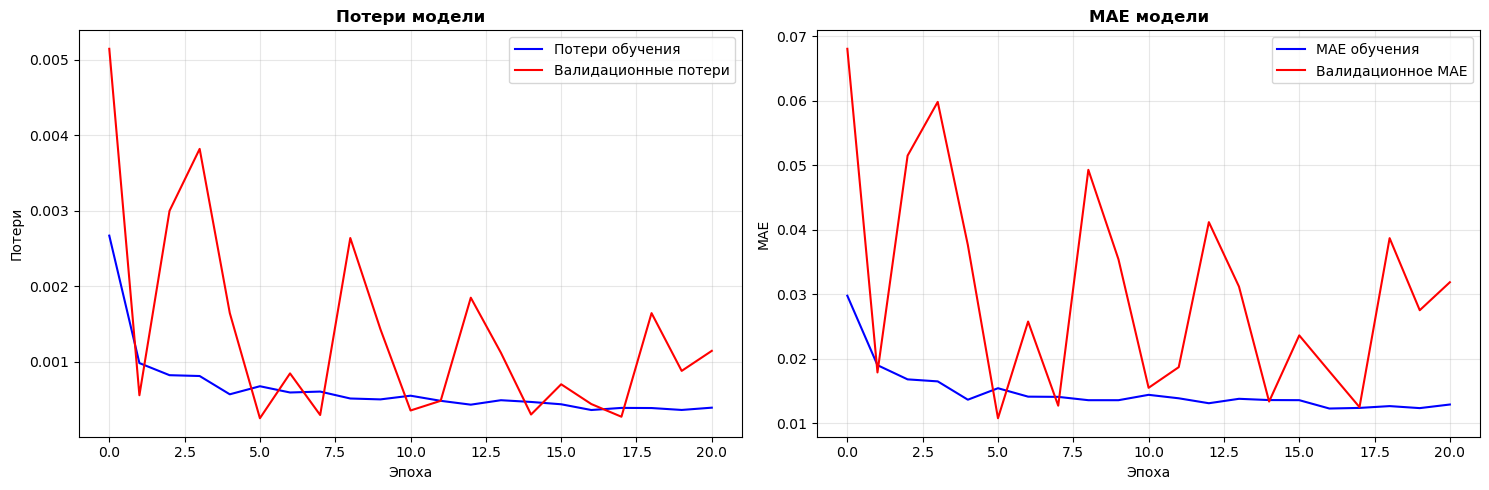

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# График потерь
ax1.plot(history.history['loss'], label='Потери обучения', color='blue')
ax1.plot(history.history['val_loss'], label='Валидационные потери', color='red')
ax1.set_title('Потери модели', fontweight='bold')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Потери')
ax1.legend()
ax1.grid(True, alpha=0.3)

# График MAE
ax2.plot(history.history['mae'], label='MAE обучения', color='blue')
ax2.plot(history.history['val_mae'], label='Валидационное MAE', color='red')
ax2.set_title('MAE модели', fontweight='bold')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Оценка модели

In [19]:
# Прогнозы на тестовых данных
predictions = model.predict(X_test)

# Функция обратного масштабирования
def inverse_transform_predictions(predictions_scaled, target_idx, scaler, n_features):
    # Создаем массив-заглушку
    dummy = np.zeros((len(predictions_scaled), n_features))
    dummy[:, target_idx] = predictions_scaled.flatten()

    # Обратное масштабирование
    inverse_scaled = scaler.inverse_transform(dummy)
    return inverse_scaled[:, target_idx]

# Обратное масштабирование
y_test_orig = inverse_transform_predictions(y_test.reshape(-1, 1), target_idx, scaler, len(features))
predictions_orig = inverse_transform_predictions(predictions, target_idx, scaler, len(features))

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


In [20]:
# Расчет метрик
mse = mean_squared_error(y_test_orig, predictions_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, predictions_orig)
r2 = r2_score(y_test_orig, predictions_orig)
mape = np.mean(np.abs((y_test_orig - predictions_orig) / y_test_orig)) * 100

print(f"МЕТРИКИ ОЦЕНКИ МОДЕЛИ:")
print(f"   MSE (Среднеквадратичная ошибка): {mse:.4f}")
print(f"   RMSE (Корень из MSE): {rmse:.4f}")
print(f"   MAE (Средняя абсолютная ошибка): {mae:.4f}")
print(f"   R² Score (Коэффициент детерминации): {r2:.4f}")
print(f"   MAPE (Средняя абсолютная процентная ошибка): {mape:.2f}%")

МЕТРИКИ ОЦЕНКИ МОДЕЛИ:
   MSE (Среднеквадратичная ошибка): 25.7168
   RMSE (Корень из MSE): 5.0712
   MAE (Средняя абсолютная ошибка): 3.8603
   R² Score (Коэффициент детерминации): 0.8235
   MAPE (Средняя абсолютная процентная ошибка): 4.66%


In [21]:
# Интерпретация результатов
if r2 > 0.8:
    print('🟢 Отличная модель (R² > 0.8)')
elif r2 > 0.6:
    print('🟡 Хорошая модель (R² > 0.6)')
elif r2 > 0.4:
    print('🟠 Удовлетворительная модель (R² > 0.4)')
else:
    print('🔴 Слабая модель (R² < 0.4)')

# Сохраняем результаты для следующих блоков
results = {
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
    'r2': r2,
    'mape': mape,
    'predictions': predictions_orig,
    'actual': y_test_orig
}

🟢 Отличная модель (R² > 0.8)


## Визуализация результатов

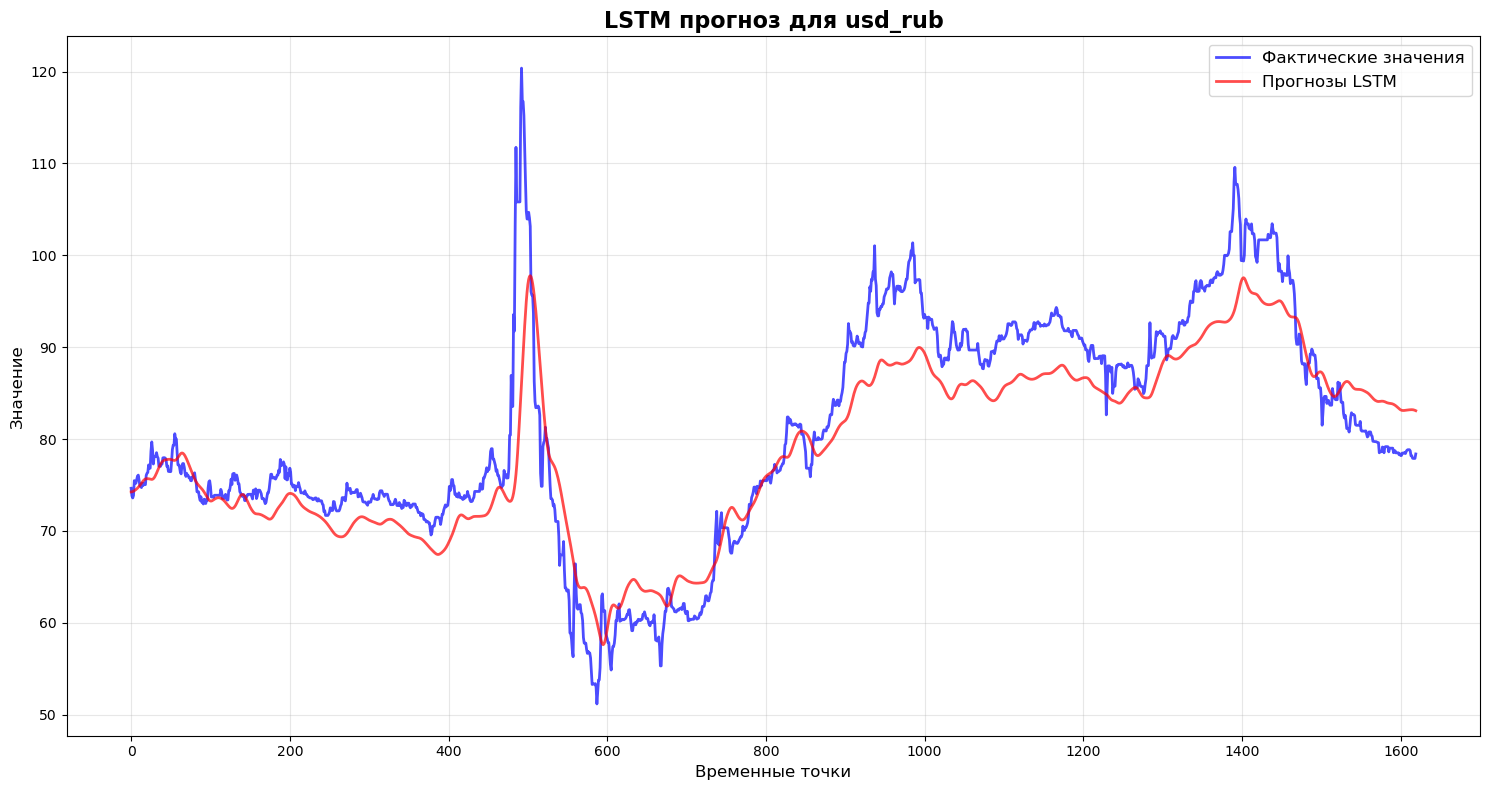

In [22]:
plt.figure(figsize=(15, 8))

plt.plot(results['actual'], label='Фактические значения', color='blue', alpha=0.7, linewidth=2)
plt.plot(results['predictions'], label='Прогнозы LSTM', color='red', alpha=0.7, linewidth=2)

plt.title(f'LSTM прогноз для {target_column}', fontsize=16, fontweight='bold')
plt.xlabel('Временные точки', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

## Прогнозирование на будущее

In [23]:
FUTURE_DAYS = 30  # Количество дней для прогноза

# Подготовка последних данных
last_data = scaled_data[-SEQUENCE_LENGTH:].copy()
future_predictions = []

# Прогнозирование по одному дню
for day in range(FUTURE_DAYS):
    # Прогноз следующего значения
    next_pred = model.predict(last_data.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)
    future_predictions.append(next_pred[0, 0])

    # Обновление последовательности
    new_row = last_data[-1].copy()
    new_row[target_idx] = next_pred[0, 0]

    # Сдвигаем окно
    last_data = np.vstack([last_data[1:], new_row.reshape(1, -1)])

    if (day + 1) % 10 == 0:
        print(f'   Выполнено прогнозов: {day + 1}/{FUTURE_DAYS}')

# Обратное масштабирование будущих прогнозов
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_values = inverse_transform_predictions(future_predictions, target_idx, scaler, len(features))

print(f'✅ Прогнозирование завершено')

# Создаем даты для будущих прогнозов
last_date = data_clean['Дата'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=FUTURE_DAYS, freq='D')

print(f" Прогнозы на следующие {FUTURE_DAYS} дней:")
for i, (date, pred) in enumerate(zip(future_dates[:10], future_values[:10])):  # Показываем первые 10
    print(f"   {date.strftime('%Y-%m-%d')}: {pred:.2f}")
if FUTURE_DAYS > 10:
    print(f"   ... и еще {FUTURE_DAYS-10} дней")

   Выполнено прогнозов: 10/30
   Выполнено прогнозов: 20/30
   Выполнено прогнозов: 30/30
✅ Прогнозирование завершено
 Прогнозы на следующие 30 дней:
   2025-07-16: 83.04
   2025-07-17: 83.02
   2025-07-18: 83.03
   2025-07-19: 83.08
   2025-07-20: 83.19
   2025-07-21: 83.33
   2025-07-22: 83.52
   2025-07-23: 83.74
   2025-07-24: 83.97
   2025-07-25: 84.23
   ... и еще 20 дней


## Визуализация будущих прогнозов

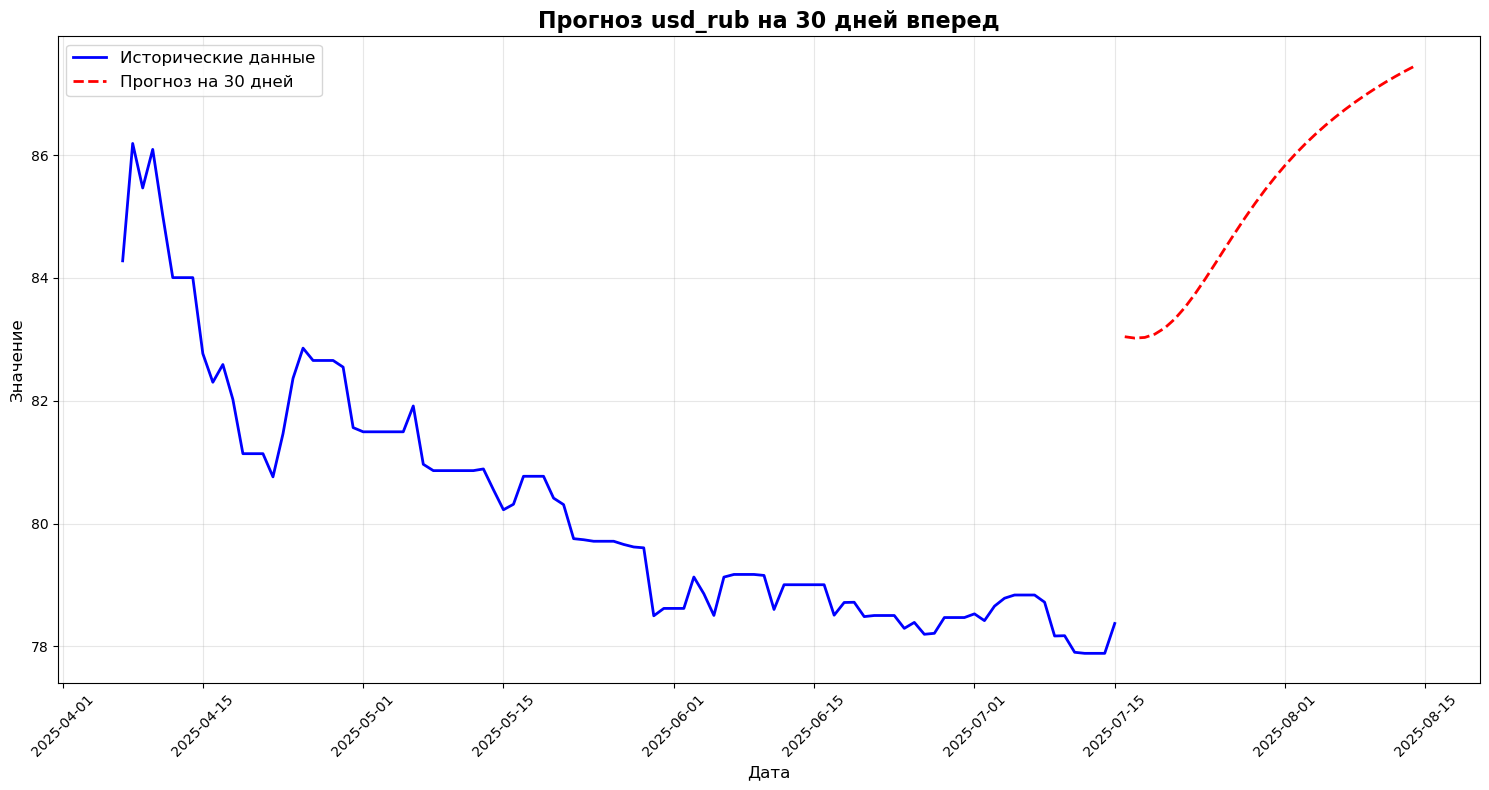

In [24]:
plt.figure(figsize=(15, 8))

# Исторические данные (последние 100 дней)
df_indexed = data_clean.set_index('Дата')
historical_data = df_indexed[target_column].dropna().tail(100)

plt.plot(historical_data.index, historical_data.values, 
         label='Исторические данные', color='blue', linewidth=2)

# Будущие прогнозы
plt.plot(future_dates, future_values, 
         label=f'Прогноз на {FUTURE_DAYS} дней', color='red', linestyle='--', linewidth=2)

plt.title(f'Прогноз {target_column} на {FUTURE_DAYS} дней вперед', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()